# Summary

Reference: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/
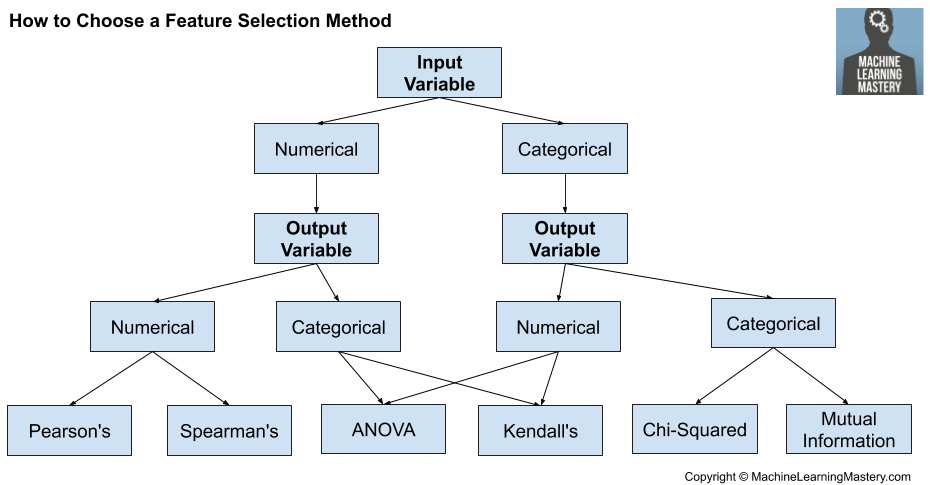

In [ ]:
import numpy as np
import pandas as pd
import os

# Plotly
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objects as go
init_notebook_mode(connected=True)

# Scikit-learn
from sklearn.datasets import load_boston as load_boston_dataset
from sklearn.datasets import load_wine as load_wine_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
# Classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
# Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import seaborn as sns

# Useful Functions

In [ ]:
SOURCE_PATH_DATA = 'resources/data/'
OUT_PATH_GRAPH = 'resources/output/graph/'

In [ ]:
def create_directory(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

def plot_graph(data, title, x_label=None, y_label=None, generate_file=True, hovermode=None,
               gridcolor='rgb(159, 197, 232)', plot_bgcolor='rgba(0, 0, 0, 0)', histogram=False):
    layout = go.Layout(
        title = title,
        xaxis = dict(
            title=x_label,
            gridcolor=gridcolor
        ),
        yaxis = dict(
            title=y_label,
            gridcolor=gridcolor
        ),
        hovermode=hovermode,
        showlegend=True,
        legend_orientation='h',
        plot_bgcolor=plot_bgcolor
    )

    fig = go.Figure(data=data, layout=layout)
    if histogram:
        fig.update_layout(barmode='overlay')
    
    if generate_file:
        generate_plot(fig, f'{OUT_PATH_GRAPH}', f'{title}.html')
    else:
        generate_plot(fig)

def generate_plot(fig, out_path=None, out_filename=None, axis_count=None,
                  gridcolor='rgb(159, 197, 232)', plot_bgcolor='rgba(0, 0, 0, 0)'):
    if axis_count is not None:
        update_axis(fig, axis_count, gridcolor)
        fig.update_layout(plot_bgcolor=plot_bgcolor)
    
    if out_path is None:
        iplot(fig)
    else:
        create_directory(out_path)
        out_file = f'{out_path}{out_filename}'
        plot(fig, filename=out_file, auto_open=False)
        
        print(f'Generated: {out_file}')

def update_axis(fig, axis_count, gridcolor='rgb(159, 197, 232)', axis_labels=None):
    for x in range(axis_count):
        suffix = x+1 if x != 0 else ''
        fig['layout'][f'xaxis{suffix}']['gridcolor'] = gridcolor
        fig['layout'][f'yaxis{suffix}']['gridcolor'] = gridcolor
        
        if axis_labels is not None:
            fig['layout'][f'xaxis{suffix}']['title'] = axis_labels[x][0]
            fig['layout'][f'yaxis{suffix}']['title'] = axis_labels[x][1]

In [ ]:
def load_santander():
    data = pd.read_csv(f'{SOURCE_PATH_DATA}santander.csv', nrows=20000)
    
    X = data.drop('TARGET', axis=1)
    y = data['TARGET']
    print(f'X.shape:    {X.shape}')
    print(f'y.shape:    {y.shape}')
    
    return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

def load_boston():
    boston = load_boston_dataset()
    
    X = pd.DataFrame(data=boston.data, columns=boston.feature_names)
    y = boston.target
    print(f'X.shape:    {X.shape}')
    print(f'y.shape:    {y.shape}')
    
    return train_test_split(X, y, test_size=0.2, random_state=0)

def load_titanic():
    data = sns.load_dataset('titanic')
    
    # Simple N/A handling
    data.drop(columns=['age', 'deck'], inplace=True)
    data.dropna(inplace=True)
    
    # Simple Categorical encoding
    categorical_features = ['sex', 'embarked', 'class', 'who', 'adult_male', 'embark_town', 'alive', 'alone']
    encoded = OrdinalEncoder().fit_transform(data[categorical_features])
    for index, feature in enumerate(categorical_features):
        data[feature] = encoded[:, index].astype(int)
    
    X = data.drop(columns=['survived', 'alive'])
    y = data['survived']
    print(f'X.shape:    {X.shape}')
    print(f'y.shape:    {y.shape}')
    
    return train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

def load_wine():
    wine = load_wine_dataset()
    
    X = pd.DataFrame(data=wine.data, columns=wine.feature_names)
    y = wine.target
    print(f'X.shape:    {X.shape}')
    print(f'y.shape:    {y.shape}')
    
    return train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
# Evaluate Accuracy, Precision & Recall
# Reference:
# - https://www.youtube.com/watch?v=VPZiJGNX4_s
# - https://www.youtube.com/watch?v=jJ7ff7Gcq34
# - https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1
def eval_classif(X_train, X_test, y_train, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred    = model.predict(X_test)
    cofmat_df = pd.DataFrame(confusion_matrix(y_test, y_pred))
    cofmat_df.index.name   = 'True'
    cofmat_df.columns.name = 'Pred'

    print(cofmat_df)
    print()
    print(classification_report(y_test, y_pred, digits=5))

# Evaluate MAE, R2 Score & RMSE
# Reference: https://medium.com/acing-ai/how-to-evaluate-regression-models-d183b4f5853d
def eval_regress(X_train, X_test, y_train, y_tes):
    model = LinearRegression(n_jobs=-1)
    model.fit(X_train, y_train)
    
    y_pred  = model.predict(X_test)
    
    print(f'MAE:      {mean_absolute_error(y_test, y_pred) :.5f}')
    print(f'R2 Score: {r2_score(y_test, y_pred) :.5f}')
    print(f'RMSE:     {np.sqrt(mean_squared_error(y_test, y_pred)) :.5f}')

# 1. Filtering Method

### 1.1. Constant Feature

- Reference: https://www.youtube.com/watch?v=nPHU1CpX4jg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3&t=0s

In [ ]:
from sklearn.feature_selection import VarianceThreshold

In [ ]:
def dropconst(train_df, test_df, unique_ratio=0):
    vt = VarianceThreshold(threshold=unique_ratio)
    vt = vt.fit(train_df)
    
    remaining_features = train_df.columns[vt.get_support(indices=True)]
    new_train_df = pd.DataFrame(
        vt.transform(train_df),
        columns=remaining_features
    )
    new_test_df  = pd.DataFrame(
        vt.transform(test_df),
        columns=remaining_features
    )
    
    return new_train_df, new_test_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove constant features (100% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test)

X_train_fs.shape, X_test_fs.shape

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 1.2. Quasi-Constant Feature

- Reference: https://www.youtube.com/watch?v=nPHU1CpX4jg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3&t=0s

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

X_train_fs.shape, X_test_fs.shape

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 1.3. Duplicate Feature

- Reference: https://www.youtube.com/watch?v=nPHU1CpX4jg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3&t=0s

In [ ]:
def dropdupl(train_df, test_df):
    duplicated_features = train_df.T.duplicated()
    remaining_features  = [not x for x in duplicated_features]
    
    new_train_df = train_df.T[remaining_features].T.copy()
    new_test_df  = test_df.T[remaining_features].T.copy()
    
    return new_train_df, new_test_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

X_train_fs.shape, X_test_fs.shape

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 1.4. Pearson Correlation Coefficients

- Reference: https://www.youtube.com/watch?v=m0fs0v5GGlg&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=3

In [ ]:
# Reference: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/
def dropcorr(train_df, test_df, corr_ratio=.95):
    # TODO - plot correlation matrix
    corrmat = train_df.corr().abs()

    # Select upper triangle of correlation matrix
    upper_df = corrmat.where(np.triu(np.ones(corrmat.shape), k=1).astype(np.bool))

    # Find index of feature columns with correlation greater than <corr_ratio>
    columns  = [x for x in upper_df.columns if any(upper_df[x] > corr_ratio)]

    new_train_df = train_df.drop(train_df[columns], axis=1)
    new_test_df  = test_df.drop(test_df[columns], axis=1)
    
    return new_train_df, new_test_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Remove correlated features
X_train_fs, X_test_fs = dropcorr(X_train_fs, X_test_fs)

X_train_fs.shape, X_test_fs.shape

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 1.5. Mutual Information

- Reference: https://www.youtube.com/watch?v=GpL_XtRVne4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=4

#### 1.5.1. Classification

In [ ]:
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectPercentile

In [ ]:
def classif_mi_features(train_df, test_df, target_df, percentile=100):
    sp = SelectPercentile(mutual_info_classif, percentile=percentile)
    sp = sp.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'score': sp.scores_
    })
    
    selected_features = train_df.columns[sp.get_support()]
    new_train_df = pd.DataFrame(
        sp.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sp.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 10% features based on mutual information values
X_train_fs, X_test_fs, eval_df = classif_mi_features(X_train_fs, X_test_fs, y_train, percentile=10)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='score', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

#### 1.5.2. Regression

In [ ]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import SelectKBest

In [ ]:
def regress_mi_features(train_df, test_df, target_df, k='all'):
    sk = SelectKBest(mutual_info_regression, k=k)
    sk = sk.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'score': sk.scores_
    })
    
    selected_features = train_df.columns[sk.get_support()]
    new_train_df = pd.DataFrame(
        sk.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sk.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_boston()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 9 features based on mutual information values
X_train_fs, X_test_fs, eval_df = regress_mi_features(X_train_fs, X_test_fs, y_train, k=9)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='score', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_regress(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_regress(X_train_fs, X_test_fs, y_train, y_test)

### 1.6. Univariate ROC_AUC (Receiver Operator Characteristic + Area Under ROC Curve)

- Reference: https://www.youtube.com/watch?v=JEfBvK91CXc&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=5

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
def rocauc_features(X_train, X_test, y_train, y_test, threshold=.5):
    # Calculate ROC-AUC scores
    rocauc_scores = []
    for feature in X_train.columns:
        model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
        model.fit(X_train[feature].to_frame(), y_train)
        
        y_pred = model.predict(X_test[feature].to_frame())
        rocauc_scores.append(roc_auc_score(y_test, y_pred))
        
    eval_df = pd.DataFrame({
        'feature': X_train.columns,
        'roc_auc': rocauc_scores
    })
    eval_df.sort_values(by='roc_auc', ascending=False, inplace=True)
    
    remaining_features = eval_df[eval_df['roc_auc'] > threshold]['feature']
    new_train_df = X_train[remaining_features].copy()
    new_test_df  = X_test[remaining_features].copy()
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select features having ROC-AUC value greater than threshold
X_train_fs, X_test_fs, eval_df = rocauc_features(X_train_fs, X_test_fs, y_train, y_test, threshold=.5)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='roc_auc', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 1.7 Univariate RMSE (Root Mean Square Error)

- Reference: https://www.youtube.com/watch?v=JEfBvK91CXc&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=5

#### 1.7.1. Regression

In [ ]:
def rmse_features(X_train, X_test, y_train, y_test, k='all'):
    # Calculate MSE
    mse = []
    for feature in X_train.columns:
        model = LinearRegression(n_jobs=-1)
        model.fit(X_train[feature].to_frame(), y_train)
        
        y_pred = model.predict(X_test[feature].to_frame())
        mse.append(mean_squared_error(y_test, y_pred))
        
    eval_df = pd.DataFrame({
        'feature': X_train.columns,
        'mse': mse
    })
    eval_df.sort_values(by='mse', ascending=True, inplace=True)
    
    k = len(X_train.columns) if k == 'all' else k
    remaining_features = eval_df[:k]['feature']
    new_train_df = X_train[remaining_features].copy()
    new_test_df  = X_test[remaining_features].copy()
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_boston()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 2 features with lowest MSE
X_train_fs, X_test_fs, eval_df = rmse_features(X_train_fs, X_test_fs, y_train, y_test, k=2)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='mse', ascending=True)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_regress(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_regress(X_train_fs, X_test_fs, y_train, y_test)

### 1.8. Univariate ANOVA Test (Analysis of Variance)

- Reference: https://www.youtube.com/watch?v=PWZLhr3FfIM&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=6

#### 1.8.1. Classification

In [ ]:
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile

In [ ]:
def classif_anova_features(train_df, test_df, target_df, percentile=100):
    sp = SelectPercentile(f_classif, percentile=percentile)
    sp = sp.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'score': sp.scores_,
        'p_value': sp.pvalues_
    })
    
    selected_features = train_df.columns[sp.get_support()]
    new_train_df = pd.DataFrame(
        sp.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sp.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_santander()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 10% features with lowest P-Value
X_train_fs, X_test_fs, eval_df = classif_anova_features(X_train_fs, X_test_fs, y_train, percentile=10)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='score', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

#### 1.8.2. Regression

In [ ]:
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import SelectKBest

In [ ]:
def regress_anova_features(train_df, test_df, target_df, k='all'):
    sk = SelectKBest(f_regression, k=k)
    sk = sk.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'score': sk.scores_,
        'p_value': sk.pvalues_
    })
    
    selected_features = train_df.columns[sk.get_support()]
    new_train_df = pd.DataFrame(
        sk.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sk.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_boston()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 3 features with lowest P-Value
X_train_fs, X_test_fs, eval_df = regress_anova_features(X_train_fs, X_test_fs, y_train, k=3)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='score', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_regress(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_regress(X_train_fs, X_test_fs, y_train, y_test)

### 1.9. Chi Square (χ2) Test

- Reference: https://www.youtube.com/watch?v=gDgEjdEzEDY&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=7

In [ ]:
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

In [ ]:
def chi2_features(train_df, test_df, target_df, k='all'):
    sk = SelectKBest(chi2, k=k)
    sk = sk.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'score': sk.scores_,
        'p_value': sk.pvalues_
    })
    
    selected_features = train_df.columns[sk.get_support()]
    new_train_df = pd.DataFrame(
        sk.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sk.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_titanic()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 2 features with lowest P-Value
X_train_fs, X_test_fs, eval_df = chi2_features(X_train_fs, X_test_fs, y_train, k=2)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='score', ascending=False)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

# 2. Wrapper Method

- Reference: https://www.youtube.com/watch?v=zW1SvA0Z-l4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=8

### 2.1. Step Forward Selection (SFS)

In [ ]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.model_selection import StratifiedKFold

In [ ]:
def stepsel_features(train_df, test_df, target_df, k, forward=True):
    sfs = SFS(
        RandomForestClassifier(n_estimators=100, random_state=0, n_jobs = -1),
        k_features=k,
        forward=forward,
        floating=False,
        verbose=2,
        scoring='accuracy',
        cv=StratifiedKFold(5),
        n_jobs=-1
    )
    sfs = sfs.fit(train_df, target_df)
    eval_df = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
    
    selected_features = sfs.k_feature_names_
    new_train_df = pd.DataFrame(
        sfs.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sfs.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_wine()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 5 features based on best result from eval_df
X_train_fs, X_test_fs, eval_df = stepsel_features(X_train_fs, X_test_fs, y_train, k=5, forward=True)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='avg_score', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 2.2. Step Backward Selection (SBS)

In [ ]:
X_train, X_test, y_train, y_test = load_wine()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top 6 features based on best result from eval_df
X_train_fs, X_test_fs, eval_df = stepsel_features(X_train_fs, X_test_fs, y_train, k=6, forward=False)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='avg_score', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 2.3. Exhaustive Feature Selection (EFS)

- No. of Combinations = C(N_features, min_N_features) + C(N_features, max_N_features)
- Reference: https://www.youtube.com/watch?v=zW1SvA0Z-l4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=8

In [ ]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

In [ ]:
def exhausel_features(train_df, test_df, target_df, min_k, max_k):
    efs = EFS(
        RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
        min_features=min_k,
        max_features=max_k,
        print_progress=True,
        scoring='accuracy',
        cv=StratifiedKFold(5),
        n_jobs=-1
    )
    efs = efs.fit(train_df, target_df)
    eval_df = pd.DataFrame.from_dict(efs.get_metric_dict()).T
    
    selected_features = efs.best_feature_names_
    new_train_df = pd.DataFrame(
        efs.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        efs.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_wine()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top features combination based on desired min & max no. of features
X_train_fs, X_test_fs, eval_df = exhausel_features(X_train_fs, X_test_fs, y_train, min_k=3, max_k=4)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='avg_score', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

# 3. Embedded Method

### 3.1. LASSO (L1 Regularization)

- Reference:
  - https://www.youtube.com/watch?v=gryKjGVgzc4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=9
  - https://www.youtube.com/watch?v=w3-g6YYANDQ

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel

In [ ]:
def lasso_features(train_df, test_df, target_df, alpha=1):
    sfm = SelectFromModel(Lasso(alpha=alpha))
    sfm = sfm.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'coef': sfm.estimator_.coef_,
        'coef_abs': np.abs(sfm.estimator_.coef_)
    })
    
    selected_features = train_df.columns[sfm.get_support()]
    new_train_df = pd.DataFrame(
        sfm.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sfm.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_titanic()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select based on L1 regularization
X_train_fs, X_test_fs, eval_df = lasso_features(X_train_fs, X_test_fs, y_train, alpha=.1)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='coef_abs', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 3.2. Ridge (L2 Regularization)

- Reference: https://www.youtube.com/watch?v=gryKjGVgzc4&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=9

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.feature_selection import SelectFromModel

In [ ]:
def ridge_features(train_df, test_df, target_df, alpha=1):
    sfm = SelectFromModel(Ridge(alpha=alpha))
    sfm = sfm.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'coef': sfm.estimator_.coef_,
        'coef_abs': np.abs(sfm.estimator_.coef_)
    })
    
    selected_features = train_df.columns[sfm.get_support()]
    new_train_df = pd.DataFrame(
        sfm.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sfm.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_titanic()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select based on L2 regularization
X_train_fs, X_test_fs, eval_df = ridge_features(X_train_fs, X_test_fs, y_train, alpha=.1)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='coef_abs', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 3.3. Elastic Net (L1 + L2 Regularization)

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.feature_selection import SelectFromModel

In [ ]:
def elasticnet_features(train_df, test_df, target_df, alpha=1, l1_ratio=.5):
    sfm = SelectFromModel(ElasticNet(alpha=alpha, l1_ratio=l1_ratio))
    sfm = sfm.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'coef': sfm.estimator_.coef_,
        'coef_abs': np.abs(sfm.estimator_.coef_)
    })
    
    selected_features = train_df.columns[sfm.get_support()]
    new_train_df = pd.DataFrame(
        sfm.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        sfm.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_titanic()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select based on balance between L1 & L2 regularization
X_train_fs, X_test_fs, eval_df = elasticnet_features(X_train_fs, X_test_fs, y_train, alpha=.1)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='coef_abs', ascending=False)

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)

### 3.4. Recursive Feature Elimination + Cross Validation (RFECV)

- Reference:
  - https://machinelearningmastery.com/feature-selection-with-categorical-data/
  - https://www.youtube.com/watch?v=pcZ4YlvhSKU&list=PLc2rvfiptPSQYzmDIFuq2PqN2n28ZjxDH&index=10
  - https://www.youtube.com/watch?v=7062skdX05Y

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

In [ ]:
def rfecv_features(train_df, test_df, target_df):
    rfecv = RFECV(
        RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1),
        step=1,
        verbose=2,
        scoring='accuracy',
        cv=StratifiedKFold(5),
        n_jobs=-1
    )
    rfecv = rfecv.fit(train_df, target_df)
    
    eval_df = pd.DataFrame({
        'feature': train_df.columns,
        'ranking': rfecv.ranking_,
        'grid_score': rfecv.grid_scores_
    })
    
    selected_features = train_df.columns[rfecv.get_support()]
    new_train_df = pd.DataFrame(
        rfecv.transform(train_df),
        columns=selected_features
    )
    new_test_df  = pd.DataFrame(
        rfecv.transform(test_df),
        columns=selected_features
    )
    
    return new_train_df, new_test_df, eval_df

In [ ]:
X_train, X_test, y_train, y_test = load_wine()

In [ ]:
# Remove quasi-constant features (99% of static values)
X_train_fs, X_test_fs = dropconst(X_train, X_test, unique_ratio=.01)

# Remove duplicate features
X_train_fs, X_test_fs = dropdupl(X_train_fs, X_test_fs)

# Select top ranking combination features
X_train_fs, X_test_fs, eval_df = rfecv_features(X_train_fs, X_test_fs, y_train)

X_train_fs.shape, X_test_fs.shape

In [ ]:
# TODO - plot eval_df
eval_df.sort_values(by='ranking', ascending=True)[:X_train_fs.shape[1]]

<font color='blue'>**Result Comparison**</font>

In [ ]:
%%time
eval_classif(X_train, X_test, y_train, y_test)

In [ ]:
%%time
eval_classif(X_train_fs, X_test_fs, y_train, y_test)